<a href="https://colab.research.google.com/github/aliakbarbadri/persian-poetry-creator/blob/master/word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt
import os

usefull links:

https://www.tensorflow.org/tutorials/text/text_generation

https://github.com/petrosDemetrakopoulos/RNN-Beatles-lyrics-generator/blob/master/model.py

# Data

In [2]:
url = "https://raw.githubusercontent.com/aliakbarbadri/persian-poetry-creator/master/shahname2.txt"
filepath = keras.utils.get_file("shahname2.txt", url)

text = open(filepath, 'rb').read().decode(encoding='utf-8')
text = text.replace("\t"," \t ").replace("\n", " \n ")
corpusList = [w for w in text.split(' ')] 
corpus_words = [i for i in corpusList if i]
# corpus_words = corpusToList(text) 
map(str.strip, corpus_words)

4554752/4553829 [==============================] - 0s 0us/step


In [3]:
vocab = sorted(set(corpus_words))
print('Corpus length (in words):', len(corpus_words))
print('Unique words in corpus: {}'.format(len(vocab)))
word2idx = {u: i for i, u in enumerate(vocab)}
idx2words = np.array(vocab)
word_as_int = np.array([word2idx[c] for c in corpus_words])

Corpus length (in words): 661330
Unique words in corpus: 19780


In [0]:
seqLength = 20
examples_per_epoch = len(corpus_words)//(seqLength + 1)
wordDataset = tf.data.Dataset.from_tensor_slices(word_as_int)
sequencesOfWords = wordDataset.batch(seqLength + 1, drop_remainder=True)
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequencesOfWords.map(split_input_target)
BATCH_SIZE = 64
BUFFER_SIZE = 100
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Model (GRU)

In [0]:
def create_model_gru(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [6]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

gru_model = create_model_gru(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)

gru_model.summary()

gru_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           5063680   
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 19780)         20274500  
Total params: 29,276,484
Trainable params: 29,276,484
Non-trainable params: 0
_________________________________________________________________


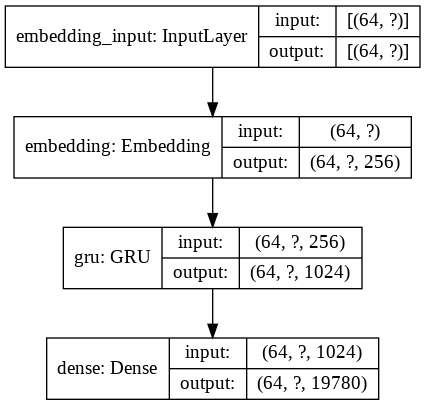

In [8]:
keras.utils.plot_model(gru_model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [0]:
history = gru_model.fit(dataset, epochs=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           5063680   
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 19780)         20274500  
Total params: 29,276,484
Trainable params: 29,276,484
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
492/492 [==============================] - 53s 108ms/step - loss: 6.4114 - accuracy: 0.1199
Epoch 2/50
492/492 [==============================] - 53s 108ms/step - loss: 5.3184 - accuracy: 0.2062
Epoch 3/50
492/492 [==============================] - 53s 109ms/step - loss: 4.7593 - accuracy: 0.2485
Epoch 4/50
492/492 [==============================] - 53s 109ms/s

In [0]:
main_gru_model = create_model_gru(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=1)
main_gru_model.set_weights(gru_model.get_weights())
main_gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            5063680   
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 19780)          20274500  
Total params: 29,276,484
Trainable params: 29,276,484
Non-trainable params: 0
_________________________________________________________________


In [0]:
def generate_text(model, start_string, temperature = 1.0):
  num_generate = 200
  start_string_list =  [w for w in start_string.split(' ')]
  input_eval = [word2idx[s] for s in start_string_list]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2words[predicted_id])
  return (start_string + ' '.join(text_generated))

In [0]:
# main_gru_model = tf.keras.models.load_model('word_gru.h5')
# main_gru_model.summary()

In [0]:
print(generate_text(main_gru_model, start_string=u"که ایران چوباغیست خرم بهار", temperature=1))

که ایران چوباغیست خرم بهار	 همیشه پرستندهٔ و چهر شاهش دلارای بود 
 به تخت از بدرهای درم داد واسب ورهی 
 یکی تاج پرگوهر شاهوار 	 ابا یاره و طوق و زرینه کفش 
 چو از پیش گودرز برخاستند 	 بفرمود تا خلعت آراستند 
 از خانهٔ بزم و آز و نیاز 	 پس او را همی فر یزدان کنیم 
 بدان نامداران گشته اسفندیار 	 که او پیشدستی نماید بکار 
 که از من بجنگ آمدی 
 من از پس گستهم بد کند رای 	 که ما هم سرای سپنج 	 گه آمد که پیچان تو اندر آریمشان 
 چو این کرده از چرخ گم شد نخست آفرین 	 ندانم که دستور باشد مرا نیکخواه 	 شوی شادمان روز من بگذرد 
 مرا از غم خویش دریا کند 	 برو بر دست تاریک پیچان کنم 
 دل چین چو درد برادر شد او برادر فروشد به خاک 	 کجا جای گیرد به دل یاد کرد 
 خردمند را چون نماید برو 	 همه پاک پشت او افسر ماه گفت 	 چنان هم که با من شب نیزه باید نهاد 	 سوی ایران کشید 	 گرفت آن سخن پیش او با سپاه 
 بدو گفت سوی کنابد بجنگ 	 برین داستان دلیران جنگی


In [0]:
main_gru_model.save("word_gru.h5")

# Model (LSTM)

In [0]:
def create_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [10]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

lstm_model = create_model_lstm(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)
lstm_model.summary()
lstm_model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           5063680   
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense_1 (Dense)              (64, None, 19780)         20274500  
Total params: 30,585,156
Trainable params: 30,585,156
Non-trainable params: 0
_________________________________________________________________


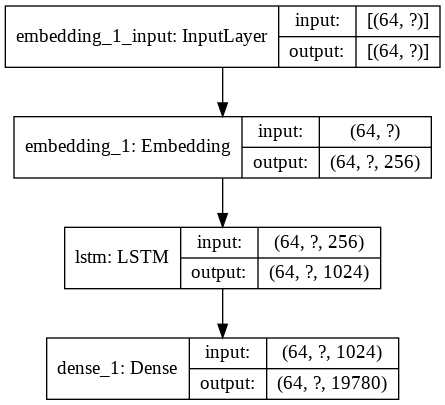

In [11]:
keras.utils.plot_model(lstm_model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [0]:
history = lstm_model.fit(dataset, epochs=50)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (64, None, 256)           5063680   
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense_2 (Dense)              (64, None, 19780)         20274500  
Total params: 30,585,156
Trainable params: 30,585,156
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
492/492 [==============================] - 53s 109ms/step - loss: 6.1890 - accuracy: 0.1117
Epoch 2/50
492/492 [==============================] - 53s 107ms/step - loss: 5.4264 - accuracy: 0.1855
Epoch 3/50
492/492 [==============================] - 53s 107ms/step - loss: 5.0092 - accuracy: 0.2268
Epoch 4/50
492/492 [==============================] - 53s 107ms

In [0]:
main_lstm_model = create_model_lstm(vocab_size = len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=1)
main_lstm_model.set_weights(lstm_model.get_weights())
main_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 256)            5063680   
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_4 (Dense)              (1, None, 19780)          20274500  
Total params: 30,585,156
Trainable params: 30,585,156
Non-trainable params: 0
_________________________________________________________________


In [0]:
# main_lstm_model = tf.keras.models.load_model('word_lstm.h5')
# main_lstm_model.summary()

In [0]:
print(generate_text(main_lstm_model, start_string=u"که ایران چوباغیست خرم بهار", temperature=0.5))

که ایران چوباغیست خرم بهار	 ز خون برادر خروشان شدند 
 همی گفت با لشکر و پهلوان 	 هشیوار و بادانش و یادگیر 
 بدو گفت پیران که ای پهلوان 	 پدرت از پی گیو پیران ز راه 
 ببستندشان دست و پای آهنست 	 نه خرگاه بود 
 چو آمد بنزدیک بر تخت خویش 	 بخون غرقه گردانم این رزمگاه 
 همه خستگان از پس یکدگر 	 بفرمود تا زنگه شاوران 
 بدان رزمگه شد فرستاده زود 	 سپه کرد و جنگ از پس پشت اوی 	 همی‌آمد از بوستان پرورش 
 چو بر گردن تیز بگذاشتند 	 همی آمد از دشت نخچیرگاه 
 یکی نامه بنوشت خوب چهر 	 چو باد دمان لشکر آنجا رسید 
 چو از دیده گه دیده‌بانش بدید 	 سران را ز لشکر بپای آورید 
 ابا جوشن و تیغ و گرز و کمند 	 همی رفت با نامور ده سوار 
 بکردند پیمان و گشتند باز 	 گرفتند کوتاه رزم دراز 
 دو سالار و بر هر سویی جامه خواست 	 چهل رش درم تنگ بسته کمر 
 سواران رومی بپیش من آر 	 که تا بگسلاند ز کینه دلی پر ز دود 
 که از ما کسی نیست جفت 
 برفتند یارانش را یکسره 	 ببشخور


In [0]:
main_lstm_model.save("word_lstm.h5")